# Initial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties

import sys
sys.path.insert(0, './SharePy')
from DataMonoClass import DataMono
from CFST_Cir_Section_Analysis import CFST_Cir_Section_Analysis
#from scipy.interpolate import interp1d, Akima1DInterpolator

#from Parse_Template import CFST_Cir_tcl
from ShareFun import monoData, smoother, genTCL
    

#Path
pathTest = 'D:/Google Drive/Python_Scripts/Test'
#File names
fileNames = np.loadtxt('./Test/file_names.txt', dtype='str')
f = open('{0}/Specimen_Group.txt'.format(pathTest))
groups = [int(item)-1 for item in f.read().split('\n')[0].split(' ')]
f.close()
#Specimen conditions
conditions = np.loadtxt('{0}/Specimen_Conditions.txt'.format(pathTest))[groups]

# Get the fcc, fyb from tests and Plot

33.4297111094 340.540750805
28.9289391953 327.106365726
34.9729087604 424.150832781
35.2166600724 413.059924571
59.8423706039 436.421983321
58.8350237027 419.792250069
77.1580539328 437.121585162
72.7838605357 423.90848241


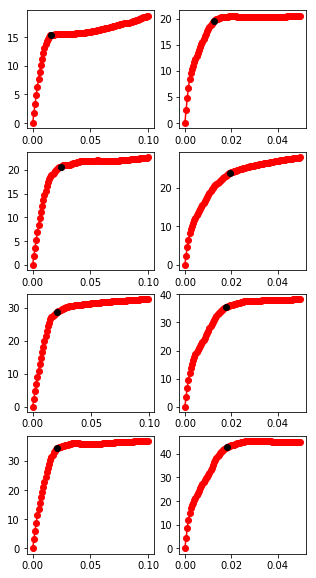

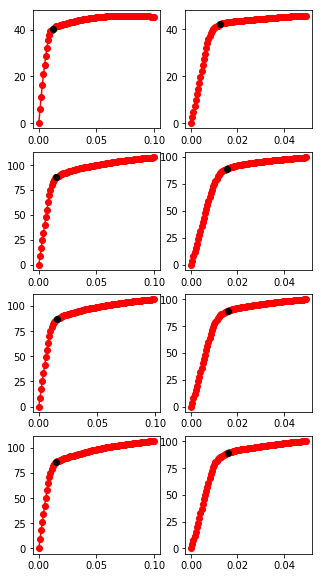

In [2]:
#Initial Parameters
yieldRatio = 0.12

figC, axesC = plt.subplots(4,2, figsize=(5,10))
figS, axesS = plt.subplots(4,2, figsize=(5,10))
axesC = axesC.flatten()
axesS = axesS.flatten()
output = np.zeros((1,6))
for i in range(len(groups)):
    axC = axesC[i]
    axS = axesS[i]
    condition = conditions[i]
    D, temp, t, L, fc, fy, fu, Naxial = condition
    data = np.loadtxt('./Test/{0}.out'.format(fileNames[i]))
    #DD, N, M, Nc, Mc, Ns, Ms = data
    data = smoother(data, col1=4, col2=0, num1=100, num2=20)
    DD, N, M, Nc, Mc, Ns, Ms = data.T
    #Plot it
    axC.plot(DD, Mc, c='r', ls='-', marker='o')
    axS.plot(DD, Ms, c='r', ls='-', marker='o')
    #Find yield moment
    dataC = DataMono(DD, Mc)
    dataS = DataMono(DD, Ms)
    tempC, Myc = dataC.findYield(yieldRatio)
    tempS, Mys = dataS.findYield(yieldRatio)
    indC = np.argwhere(Mc==Myc)[0,0]
    indS = np.argwhere(Ms==Mys)[0,0]
    axC.plot(tempC, Myc, c='k', marker='o')
    axS.plot(tempS, Mys, c='k', marker='o')
    #Find the fcc and fyb
    curCFST = CFST_Cir_Section_Analysis(D, t, fc, fy)
    fcc1, cur_h = curCFST.getfcAvg(Nc[indC]*1.0e3, Mc[indC]*1.0e6)
    fcc2, cur_h = curCFST.getfcAvg(Nc[-1]*1.0e3, Mc[-1]*1.0e6)
    fcc = min(fcc1, fcc2)
    fyb, cur_h = curCFST.getfyAvg(Ns[indS]*1.0e3, Ms[indS]*1.0e6)
    print(fcc, fyb)
    output = np.vstack((output, [D, t, L, fcc, fyb, Naxial]))
output = output[1:]
np.savetxt('./Test/condition_Method.out', output)  

# Gnerate Tcl files

In [4]:
file_path = './Test/Method'
conditionName = './Test/condition_Method.out'
genTCL(file_path, conditionName)

# Plot the verification 

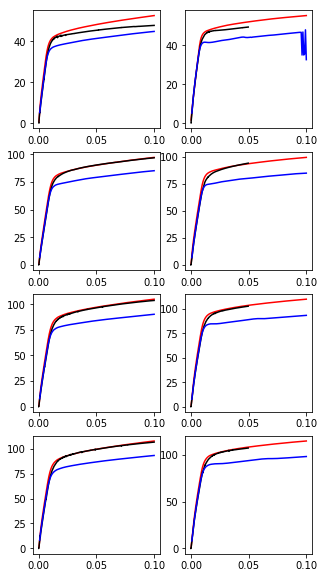

In [5]:
def plotVerificationMethod(pathTest):
    file_path = './Test/Method'
    conditionName = './Test/condition_Method.out'
    file_names = np.loadtxt('./Test/file_names.txt', dtype='str')
    conditions = np.loadtxt(conditionName)
    #Load Specimen group
    f = open('{0}/Specimen_Group.txt'.format(pathTest), 'r')
    groups = [int(item)-1 for item in f.read().split('\n')[0].split(' ')]
    f.close()

    #Load the specimen data
    Conditions = np.loadtxt('{0}/Specimen_Conditions.txt'.format(pathTest))[groups]
    fig, axes = plt.subplots(4,2, figsize=(5,10))
    axes = axes.flatten()
    for i in range(len(conditions)):
        file_name = file_names[i]
        D, t, L, fc, fy, N_axial = conditions[i]
        drift = np.loadtxt('{0}/{1}.out_disp.out'.format(file_path, file_name)) / L
        force = np.loadtxt('{0}/{1}.out_moment.out'.format(file_path, file_name)) / 1e3 / L
        dataAB = np.loadtxt('{0}/ABAQUS/{1:.0f}_FE.txt'.format(pathTest, groups[i]+1)).T
        dataDP = np.loadtxt('{0}/OpenSees_DP/{1:.0f}_DP.out'.format(pathTest, groups[i]+1)).T
        dataAB[0] /= L
        dataDP[0] /= L
        ax = axes[i]
        ax.plot(drift, force, c='r')
        ax.plot(dataAB[0], dataAB[1], c='k')
        ax.plot(dataDP[0], dataDP[1], c='b')
plotVerificationMethod(pathTest)